# DCGan 
Convolutional Layer 를 이용한 GAN 이미지 생성 모델

- 논문: https://arxiv.org/pdf/1511.06434.pdf
- 파이 토치 튜토리얼: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import os
import random
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random Seed 설정--->코드에서 사용하는 랜덤값을 생성하는 모든 lib에 설정하다.
seed_value = 0
random.seed(seed_value)
torch.manual_seed(seed_value)
np.random.seed(seed_value)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# 하이퍼파라미터 변수 정의

- **dataroot:** 학습데이터셋 저장 디렉토리 경로
- **workers:** `DataLoader`로 데이터를 로드하기 위한 쓰레드 개수.
- **batch_size:** 배치 크기. DCGAN **논문에서는 128**의 배치 크기를 사용.
- **image_size:** 훈련에 사용되는 이미지의 크기. 여기서는 64 X 64 사용.
- **nc:** 입력 이미지의 컬러 채널 수. 컬러일 경우 3.
- **nz:** Latent vector 의 길이. Fake 이미지를 만들때 입력할 데이터.
- **ngf:** 제너레이터의 레이어들을 통과한 특징 맵크기의 기본값으로 레이어 별로 이 값에 * N한 값을 out features로 설정.
- **ndf:** 판별기의 레이어들을 통과한 특징 맵크기의 기본값으로 레이어 별로 이 값에 * N한 값을 out features로 설정.
- **num_epochs:** Train 에폭 수입니다. 더 오래 훈련할수록 더 나은 결과를 얻을 수 있지만 시간도 훨씬 더 오래 걸린다.
- **lr:** 훈련에 대한 학습률. DCGAN 논문에서 0.0002를 사용.
- **beta1:** 아담 옵티마이저를 위한 베타1 하이퍼파라미터. 논문에서 0.5를 사용.
- **ngpu:** 사용 가능한 GPU 개수. 0이면 CPU 모드에서 실행되고 0보다 크면 해당 수의 GPU에서 실행된다.

In [3]:
# 하이퍼파라미터 변수 설정

dataroot = r"datasets" #train dataset을 저장할 디렉토리
os.makedirs(dataroot,exist_ok=True)

#cpu_count() : cpu로 할 수 있는 병렬처리의 최대 개수이다.
workers = os.cpu_count() #dataloader 사용. data load시 사용할 thread의 개수이다.
batch_size = 128
image_size = 64 # 학습 이미지의 h,w 크기. (64*64를 학습시킨다.)
nc = 3 #입력 이미지의 channel 수이다.
nz = 100 # Latent vector의 크기. ->Generator의 입력 데이터.(표준분포를 따르는 random 값들로 구성한다.)
ngf = 64 # G(enerative) 출력 F(eature map) 개수에 사용할 값.
ndf = 64 # D(iscriminator-판별자) 출력 F(eature map) 개수에 사용할 값.
num_epochs = 10
lr = 0.0002
beta1 = 0.5 #Adam 옵티마이저의 하이퍼파라미터값.
ngpu = 1 if device == 'cuda' else 0

# 학습 데이터셋 - celeb-A face dataset
- 유명인사들의 얼굴 사진들
- torchvision의 built-in dataset으로 받을 수 있다.
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.CelebA.html#torchvision.datasets.CelebA
- 다음 사이트에서도 다운로드 받을 수 있다.
    - http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    - 다운 받은 뒤 압축을 풀면 디렉토리구조가 다음과 같다.
    - 이것을 ImageFolder 를 이용해 Dataset으로 구성할 수 있다.
    ```
    /path/to/celeba
        -> img_align_celeba
            -> 188242.jpg
            -> 173822.jpg
            -> 284702.jpg
            -> 537394.jpg
    ```


## Dataset, DataLoader 생성

In [5]:
from zipfile import ZipFile

with ZipFile(os.path.join(dataroot, "img_align_celeba.zip")) as zfile:
    zfile.extractall(os.path.join(dataroot))

In [5]:
#import shutil ##파일/디렉토리 카피, 복사 옮기기, 이동 함수 제공.
#os.makedirs('datasets/celeba/',exist_ok = True)


#shutil.move("datasets/img_align_celeba/","datasets/celeba")

#여러번 실행하면 오류난다.

In [7]:
# Dataset, DataLoader 생성
transform = transforms.Compose([
    transforms.Resize(image_size), #Resize((h,w)), Resize(정수):h/w 중 짧은 쪽의 크기를 지정. 긴쪽은 원본 이미지 종횡비에 맞춰 resize한다.
    transforms.CenterCrop(image_size), #CenterCrop(정수) #정수 x 정수
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ]) # -1.0에서 1.0 사이로 픽셀 값이 만들어진다.

dataset = datasets.ImageFolder(root='datasets/celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [ ]:
## Built-in
########################################################################################
# Google Drive에서 다운 받는데 다운 횟수 limit가 있어서 못 받을 수 있다.
########################################################################################
# dataset = datasets.CelebA(root=dataroot, split="all", target_type=["attr", "identity"], download=True,
#                          transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ])
#                          )
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

## 다운받은 일부 이미지 확인

- vutils.make_grid: https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html
- 여러 이미지 Tensor 를 하나로 합친 Tensor를 반환한다.
- Parameter 
    - **tensor (Tensor or list)**: 4D mini-batch Tensor (Batch, Channel, Height, Width) 또는 같은 크기의 이미지 리스트   
    - **nrow (int, optional):** 한 행에 표시될 이미지의 개수. 최종 그리드의 형태는 ( Batch / nrow, nrow )가 된다. (Default : 8)   
    - **padding (int, optional)**: 이미지 사이 간격 pdding (Default : 2)
    - **normalize (bool, optional)**: True 일 경우, image 를 0~1 값으로 변환. (value_range 파라미터의 min, max 값을 기준) (Default : False)   
    - **pad_value (float, optional)**: 패딩 되는 픽셀의 값 (Default : 0)   

In [8]:
real_batch = next(iter(dataloader))

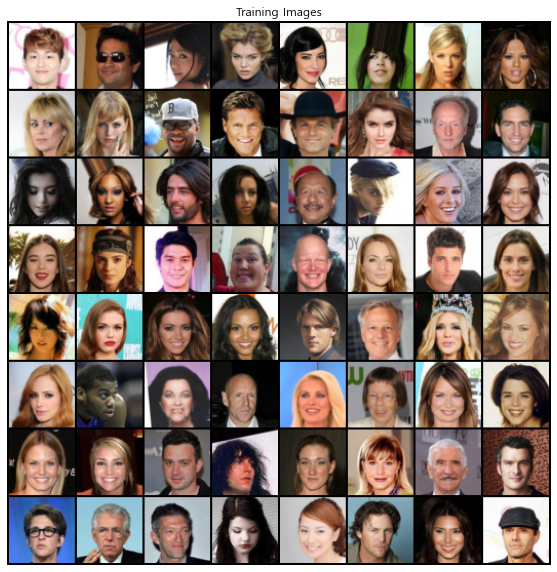

In [9]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch[0][:64]  #0:X , [:64] 128장 중 앞 64장
                            , padding=2
                            , normalize=True).permute(1, 2, 0))
plt.show()

# 모델 정의
GAN 모델은 Generator와 Discriminator 두 개 모델을 정의한다.

## 모델을 구성하는 Layer의 파라미터 초기화
- DCGAN 논문에서 저자에서  모든 모델 가중치를 평균=0, 표준편차=0.02의 정규 분포에서 무작위로 초기화하도록 한다.   
- `weights_init()` 함수는 Random값으로 초기화된 모델을 입력으로 받아 위 기준을 충족하도록 모든 convolution, convolution-transpose 및 Batch Normalization 레이어의 파라미터들을 다시 초기화한다.

In [11]:
a=nn.Conv2d(10,10,3)
cn = a.__class__.__name__
cn.find("Conv") #문자열A.find("문자열b") -> 문자열a에 문자열b가 어디있는지 찾게하는 것.
cn.find("Batch")

-1

In [16]:
a.weight.data
a.bias.data

tensor([ 0.0264,  0.0575,  0.0833,  0.0208,  0.0358, -0.0824, -0.0283,  0.0096,
         0.0128, -0.0372])

In [17]:
## 논문에 따라 레이어의 파라미터들을 초기화하는 함수.
# nn.init.normal_(텐서, 평균, 표준편차): 텐서를 평균, 표준편차를 따르는 정규분포의 난수들로 채운다.
# nn.init.constant_(텐서, value): 텐서를 value:float 으로 채운다.
def weights_init(m:"Layer"):
    
    classname = m.__class__.__name__ #레이어객체의 클래스이름
    if classname.find('Conv') != -1: #Convolution Layer의 경우
        nn.init.normal_(m.weight.data, 0.0, 0.02) # weight을 평균 0, 표준편차 0.02를 따르는 random값으로 변경한다.
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

- Generator는 **Latent space Vector(잠재공간벡터) 를 입력** 받아 training image와 동일한 형태(분포)의 **이미지를 생성** 한다.
    - Latent space Vector는 GAN의 입력데이터로 동일한 분포(보통 정규분포)의 random 값으로 구성된다. random 값이 어떻게 구성되느냐에 따라 다른 이미지가 생성된다.
- Generator는 Strided Transpose Convolution, Batch Normalization, ReLU 로 이어지는 layer block들로 구성된다.
    - **Strided Convolution** pooling layer를 사용하지 않고 stride를 이용해 size를 조정하는 것을 말함.
    - **Transpose Convolution** 은 Convolution을 역으로 계산한다. 보통 Upsampling에 사용된다.
- Generator의 최종 출력은 \[-1, 1\] 범위의 결과를 리턴한다. 그래서 출력 Layer의 activation 함수로 **tanh**를 사용한다.


![paper](https://pytorch.org/tutorials/_images/dcgan_generator.png)<br>
\[DCGAN paper의 Generactor 구조\]

> ### Transpose Convolution Layer 출력 size 공식
> - i: input 크기
> - k: kernel 크기
> - s: stride
> - p: padding
> 
>$$
r\_size = k + (i-1)\times{s} - 2\times{p}
$$

In [22]:
i_s = 64 #input size
k_s = 4 #kernel 크기
s = 1 #stride
p = 0 #padding
(k_s+(i_s - 1)*s -2*p) #이렇게 계산하면 size가 나온다.


67

In [24]:
i_data = torch.ones((1,1,64,64)) #견본 데이터를 정의한다.

In [27]:
layer = nn.ConvTranspose2d(in_channels=1,out_channels=3,kernel_size=4,stride=2,padding=1)
i_data = torch.ones((1,1,64,64)) #견본 데이터를 정의한다.
result = layer(i_data)
print(result.shape) #사이즈가 변경이 되는 것을 볼 수 있다.
#사이즈의 변경은 layer의 변수들을 변경하는 것이다.
#특히, stride나 padding의 값에 따라 result의 shape이 바뀌는 것을 주목하자.




torch.Size([1, 3, 128, 128])


In [29]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            #input: (100,1,1)->(64*8*8)
            
            nn.ConvTranspose2d(in_channels=nz, 
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1,
                               padding=0, 
                               bias=False),
            nn.BatchNorm2d(ngf * 8), #앞의 out_channel이 input으로!
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), #점점 출력 channel 수를 좁혀나간다.
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

Generator를 생성하고 `weights_init` 함수를 적용한다.

In [30]:
# Generator 생성
netG = Generator(ngpu).to(device)

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

- Discriminator는 trainset의 진짜 이미지와 generator가 생성한 가짜 이미지를 분류하는 역할을 한다. 이미지를 입력받아 이진분류를 해서 진짜이미지 인지 여부의 확률값을 출력한다.
- 모델의 구조는 Strided Convolution layer, Batch normalization, LeakyReLU 로 구성된 layer block들을 통과한 뒤 sigmoid activation 함수를 통해 최종 확률값을 출력한다.
    - 논문에서 Activation 함수로 ReLU가 아닌 LeakyReLU를 사용한 것이 특징이다.
    - 논문에서는 down sampling을 max pooling 이 아니라 convolution layer의 stride를 이용해 줄여 나간다.
        - 이유는 pooling layer를 사용할 경우 convolution layer가 pooling 함수를 학습하게 되기 때문이라고 한다. (convolution layer가 입력의 특성을 찾는 것 뿐만 아니라 어떻게 max pooling에 적용해야 할지 까지 학습하게 된다.)
 
![discriminator](figures/gan/discriminator.png)

In [31]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #이런 과정들을 거쳐서 결국에는 출력값을 1개로 만든다.
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
# Discriminator 생성
netD = Discriminator(ngpu).to(device)

#모델.apply(함수) => 함수에 모델의 레이어들을 전달. =>레이어 파라미터 값을 함수를 이용해 초기화할 때 사용한다.
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 학습
## Loss 함수와 Optimizers

- GAN 모델의 최종 출력은 Real image인지 여부이므로 이진분류 문제이다.
- Loss 함수는 Binary Cross Entropy loss (BCELoss) 함수를 사용.

In [33]:
import torch
torch.optim.Adam?

In [35]:
criterion = nn.BCELoss()
#generator/판별자 모두 판별자의 오차를 바탕으로 업데이트를 한다. 그래서 BCELoss를 쓴다.

#학습하는 도중 중간중간 생성자가 생성한 이미지를 지정한다. 그때 사용할 입력 데이터(latent vector)
#표준정규분포를 따르는 난수로 구성. shape: (개수,100(nz),1,1)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1. #진짜 이미지(train data)의 label
fake_label = 0. #가짜 이미지(생성자가 만든 데이터)의 label

#판별자를 최적화할 옵티마이저.
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
###생성자(generator)를 최적화할 옵티마이저.
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
#생성자 만든 가짜 이미지를 저장할 리스트(확인용)
img_list = [] 

#Generator, Discriminator의 loss들을 저장할 리스트이다.
G_losses = []
D_losses = []
iters = 0   #몇번째 step인지를 저장할 변수

print("Starting Training Loop...")

s_all = time.time() ##전체 학습 시간을 계산한다.
for epoch in range(num_epochs):
    
    s = time.time() ##에폭별 학습 시간을 계산한다.
    for i, data in enumerate(dataloader, 0):

        #한 step
        ####################################################################################
        # (1) Update Discriminator(판별자) network Traing
        ###################################################################################
        netD.zero_grad() #gradient 초기화

        #X(진짜 이미지)
        real_cpu = data[0].to(device) #data:(X,y)로 이뤄져있는 튜플. data[0]: 이미지
        
        b_size = real_cpu.size(0) #(batch,c,h,w) ->데이터수
        #y(정답) - 1
        
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        ### 모델 추정 ===>진짜인지의 여부를 출력한다.
        
        output = netD(real_cpu).view(-1)
        #flatten을 통해 다차원으로 이뤄져 있는 배열을 1차원르로 바꾼다.
        
        errD_real = criterion(output, label)
        ###판별자가 진짜 이미지를 추론한 결과의 오차를 구한다.
        
        
        errD_real.backward()
        #연산을 다 한 다음, gradient를 계산한다.
        
        #판별자가 real image에 대해 맞춘 비율(정확도)
        D_x = output.mean().item()
        
        
        #가짜 이미지를 생성한다. - 가짜 이미지에 대한 input data를 생성한다.
        # Generator의 입력 vector를 생성한다. (100,1,1)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        
        #이미지 생성(X)
        fake = netG(noise)  
        
        ## 정답(y) - 0.0
        label.fill_(fake_label) #Tensor객체.fill_(값) 텐서의 값을 "값"으로 다 변경.
        
        #### 가짜 이미지를 판별자를 통해 판별한다.
        output = netD(fake.detach()).view(-1) #Tensor객체.detach() : 계산그래프에서 뺀다.
        # Tensor객체. detach(): 계산그래프에서 뺀다. Tensor 객체의 값만 복사한 tensor를 반환한다.
        
        
        errD_fake = criterion(output, label) #판별자가 가짜 이미지에 대한 추정결과의 오차를 계산한다.
        
        #gradient 계산
        errD_fake.backward()
        
        
        ### 판별자 파라미터들의 gradient는 가짜 + 진짜에 대한 gradient 합이다.
        D_G_z1 = output.mean().item() # 가짜 이미지에 대해서 틀린 것의 비율을 구한다.
        
        #현재 step에서 판별자의 loss -> 진짜이미지에 대한 loss + 가짜 이미지에 대한 loss
        errD = errD_real + errD_fake
        
        
        #판별자의 파라미터 업데이트
        optimizerD.step()

        #######################################################
        # (2) Update Generator(생성자) network Traning
        #######################################################
        netG.zero_grad()
        
        label.fill_(real_label) 
        
        output = netD(fake).view(-1) 
        
        errG = criterion(output, label)
        
        errG.backward()
        
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        
        if i % 50 == 0:
            print('[%02d/%d][%04d:/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'.format(epoch+1,
                                                                                                             num_epochs, 
                                                                                                             i,
                                                                                                             len(dataloader),
                                                                                                             errD.item(), 
                                                                                                             errG.item(), 
                                                                                                             D_x, 
                                                                                                             D_G_z1, 
                                                                                                             D_G_z2 
                                                                                                            ))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        #500 step에 한번씩, 마지막 에폭의 마지막 step일 경우
        #generator가 생성한 가짜 이미지를 저장한다. - fixed_noise를 입력으로 사용한다.
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    e = time.time() #시간을 잰다.
    print(f"{epoch+1} epoch 걸린시간: {e-s}초")
    
e_all = time.time()
print(f"총 걸린 시간: {e_all - s_all}초")

In [ ]:
### 학습결과 시각화
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def show_fake_image(idx):
    """학습도중 저장한 fake 이미지를 출력"""
    plt.figure(figsize=(10,10))
    img = img_list[idx].permute(1,2,0)
    plt.imshow(img)
    plt.show()
    
show_fake_image(32)

In [ ]:
# Tain set의 이미지와 생성한 이미지 비교
# real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).permute(1,2,0))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()